# Worm Simulation on 2D Ising Lattice

# Imports

In [70]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
import os
#from operator import xor
#from blocks import Blocks
from worm_simulation import WormSimulation
from bonds import Bonds
from specific_heat import SpecificHeat
from pca import PrincipalComponent
#from iterated_blocking import *
#from count_bonds import *
from specific_heat import SpecificHeat
from count_bonds import *
import matplotlib.image as mpimg
from matplotlib.offsetbox import AnchoredText
import matplotlib.offsetbox as offsetbox

%autoreload 2
%matplotlib notebook
import matplotlib as mpl
label_size = 14
plt.rc('font', family='serif')
plt.rc('text', usetex=True)
mpl.rcParams['xtick.labelsize'] = label_size 
mpl.rcParams['ytick.labelsize'] = label_size 

Tc =  2./np.log(1+np.sqrt(2))    # critical temperature

# Generate Data

In [3]:
##########################################################
#        Feel free to change parameters as needed        #
##########################################################
for i in range(10):
    print("\n" + 80*"*" + "\n")
    print("Run #: {}".format(i))
    print("\n" + 80*"*" + "\n")
    # run from 1.0 to 3.5 in steps of 0.1
    bonds4 = Bonds(4, run=True, num_steps=1E8)
    bonds8 = Bonds(8, run=True, num_steps=1E8)
    bonds16 = Bonds(16, run=True, num_steps=1E8)
    bonds32 = Bonds(32, run=True, num_steps=1E7)
    # run from 1.8 to 2.8 in steps of 0.05
    bonds32 = Bonds(32, run=True, num_steps=1E8, 
                    T_start=1.8, T_end=2.8, T_step=0.05)
    bonds16 = Bonds(16, run=True, num_steps=1E8, 
                    T_start=1.8, T_end=2.8, T_step=0.05)
    bonds8 = Bonds(8, run=True, num_steps=1E8, 
                   T_start=1.8, T_end=2.8, T_step=0.05)
    bonds4 = Bonds(4, run=True, num_steps=1E8, 
                   T_start=1.8, T_end=2.8, T_step=0.05)

compilation -- start

compilation -- done



TypeError: exceptions must derive from BaseException

# Data Analysis

## Specific Heat

In [ ]:
specific_heat32 = SpecificHeat(32)
specific_heat16 = SpecificHeat(16)
specific_heat8 = SpecificHeat(8)
specific_heat4 = SpecificHeat(4)

## $\langle N_b \rangle$, and $\langle \Delta_{N_b}^2\rangle$

### L = 4

In [ ]:
count_bonds4 = CountBonds(4, verbose=False, num_blocks=5)
# 2m 41s

Nb4 = np.array([
    (i[0], i[1]) for i in sorted(list( count_bonds4.bond_stats.values()))
])
delta_Nb4 = np.array([
    (i[2], i[3]) for i in sorted(list(count_bonds4.bond_stats.values()))
])
Nb4_temps = np.array([
    float(i) for i in sorted(list(count_bonds4.bond_stats.keys()))
])

#########################
#        BLOCKED        #
#########################
count_bonds4b = CountBonds(4, block_val=0, verbose=False, num_blocks=5)
# 2m 4b1s using num_blocks=10

Nb4b = np.array([
    (i[0], i[1]) for i in list(count_bonds4b.bond_stats.values())
])
delta_Nb4b = np.array([
    (i[2], i[3]) for i in list(count_bonds4b.bond_stats.values())
])
Nb4b_temps = np.array([
    float(i) for i in list(count_bonds4b.bond_stats.keys())
])

### L = 8

In [ ]:
count_bonds8 = CountBonds(8, verbose=False, num_blocks=5)
# 7m 48s for num_blocks=10, 20k lines
# 2m 8s for num_blocks=5, 10k lines

Nb8 = np.array([
    (i[0], i[1]) for i in list(count_bonds8.bond_stats.values())
])
delta_Nb8 = np.array([
    (i[2], i[3]) for i in list(count_bonds8.bond_stats.values())
])
Nb8_temps = np.array([
    float(i) for i in list(count_bonds8.bond_stats.keys())
])

#########################
#        BLOCKED        #
#########################
count_bonds8b = CountBonds(8, block_val=0, verbose=False, num_blocks=5)
# 2m 8b1s using num_blocks=10

Nb8b = np.array([
    (i[0], i[1]) for i in sorted(list(count_bonds8b.bond_stats.values()))
])
delta_Nb8b = np.array([
    (i[2], i[3]) for i in sorted(list(count_bonds8b.bond_stats.values()))
])
Nb8b_temps = np.array([
    float(i) for i in sorted(list(count_bonds8b.bond_stats.keys()))
])

### L = 16

In [ ]:
count_bonds16 = CountBonds(16, verbose=False, num_blocks=5)
# 24m 42s with num_blocks=10, 20k lines

Nb16 = np.array([
    (i[0], i[1]) for i in list(count_bonds16.bond_stats.values())
])
delta_Nb16 = np.array([
    (i[2], i[3]) for i in list(count_bonds16.bond_stats.values())
])
Nb16_temps = np.array([
    float(i) for i in list(count_bonds16.bond_stats.keys())
])

#########################
#        BLOCKED        #
#########################
count_bonds16b = CountBonds(16, block_val=0, verbose=False, num_blocks=5)
# 2m 16b1s using num_blocks=10

Nb16b = np.array([
    (i[0], i[1]) for i in sorted(list(count_bonds16b.bond_stats.values()))
])
delta_Nb16b = np.array([
    (i[2], i[3]) for i in sorted(list(count_bonds16b.bond_stats.values()))
])
Nb16b_temps = np.array([
    float(i) for i in sorted(list(count_bonds16b.bond_stats.keys()))
])

### L = 32

In [ ]:
count_bonds32 = CountBonds(32, verbose=False, num_blocks=3)
# 25m 26s num_blocks=5
# 19m 32s num_blocks=3

Nb32 = np.array([
    (i[0], i[1]) for i in list(count_bonds32.bond_stats.values())
])
delta_Nb32 = np.array([
    (i[2], i[3]) for i in list(count_bonds32.bond_stats.values())
])
Nb32_temps = np.array([
    float(i) for i in list(count_bonds32.bond_stats.keys())
])

#########################
#        BLOCKED        #
#########################

count_bonds32b = CountBonds(32, block_val=0, verbose=False, num_blocks=5)
# 2m 32b1s using num_blocks=10

Nb32b = np.array([
    (i[0], i[1]) for i in list(count_bonds32b.bond_stats.values())
])
delta_Nb32b = np.array([
    (i[2], i[3]) for i in list(count_bonds32b.bond_stats.values())
])
Nb32b_temps = np.array([
    float(i) for i in list(count_bonds32b.bond_stats.keys())
])

## Principal Component Analysis $(\lambda_1)$

### L = 4

In [ ]:
pca4 = PrincipalComponent(4, num_blocks=5, verbose=False)
# 1m 46.4 s with num_blocks = 10, 20k lines
# 49.5s with num_blocks = 5, 20k lines

pca4_temps = [float(i) for i in list(pca4._eig_vals.keys())]
pca4_vals = [i[0][0] for i in list(pca4._eig_vals.values())]
pca4_err = list(pca4._err.values())

#########################
#        BLOCKED        #
#########################
pca4b = PrincipalComponent(4, block_val=0, num_blocks=5, verbose=False)
# 1m 46.4 s with num_blocks = 10, 20k lines
# 49.5s with num_blocks = 5, 20k lines

pca4b_temps = [float(i) for i in list(pca4b._eig_vals.keys())]
pca4b_vals = [i[0][0] for i in list(pca4b._eig_vals.values())]
pca4b_err = list(pca4b._err.values())

### L = 8

In [ ]:
pca8 = PrincipalComponent(8, num_blocks=5, verbose=False)
# 3m 5s with num_blocks=10, 20k lines
# 38.3 s with num_blocks=10, 10k lines

pca8_temps = [float(i) for i in list(pca8._eig_vals.keys())]
pca8_vals = [i[0][0] for i in list(pca8._eig_vals.values())]
pca8_err = list(pca8._err.values())

#########################
#        BLOCKED        #
#########################
pca8b = PrincipalComponent(8, block_val=0, num_blocks=5, verbose=False)
# 1m 86.8 s with num_blocks = 10, 20k lines
# 89.5s with num_blocks = 5, 20k lines

pca8b_temps = [float(i) for i in list(pca8b._eig_vals.keys())]
pca8b_vals = [i[0][0] for i in list(pca8b._eig_vals.values())]
pca8b_err = list(pca8b._err.values())

### L = 16

In [ ]:
pca16 = PrincipalComponent(16, num_blocks=5, verbose=False)
# 10m 6s with num_blocks=10, 20k lines
# 2m 42s with num_blocks=5, 5

pca16_temps = [float(i) for i in list(pca16._eig_vals.keys())]
pca16_vals = [i[0][0] for i in list(pca16._eig_vals.values())]
pca16_err = list(pca16._err.values())

#########################
#        BLOCKED        #
#########################
pca16b = PrincipalComponent(16, block_val=0, num_blocks=5, verbose=False)
# 1m 166.16 s with num_blocks = 10, 20k lines
# 169.5s with num_blocks = 5, 20k lines

pca16b_temps = [float(i) for i in list(pca16b._eig_vals.keys())]
pca16b_vals = [i[0][0] for i in list(pca16b._eig_vals.values())]
pca16b_err = list(pca16b._err.values())

### L = 32

In [ ]:
pca32 = PrincipalComponent(32, num_blocks=5)
# 41m 33s with num_blocks=10, 20k lines

pca32_temps = [float(i) for i in list(pca32._eig_vals.keys())]
pca32_vals = [i[0][0] for i in list(pca32._eig_vals.values())]
pca32_err = list(pca32._err.values())

#########################
#        BLOCKED        #
#########################
pca32b = PrincipalComponent(32, block_val=0, num_blocks=5, verbose=False)
# 1m 326.32 s with num_blocks = 10, 20k lines
# 329.5s with num_blocks = 5, 20k lines

pca32b_temps = [float(i) for i in list(pca32b._eig_vals.keys())]
pca32b_vals = [i[0][0] for i in list(pca32b._eig_vals.values())]
pca32b_err = list(pca32b._err.values())

# PLOTS

## Energy

<IPython.core.display.Javascript object>


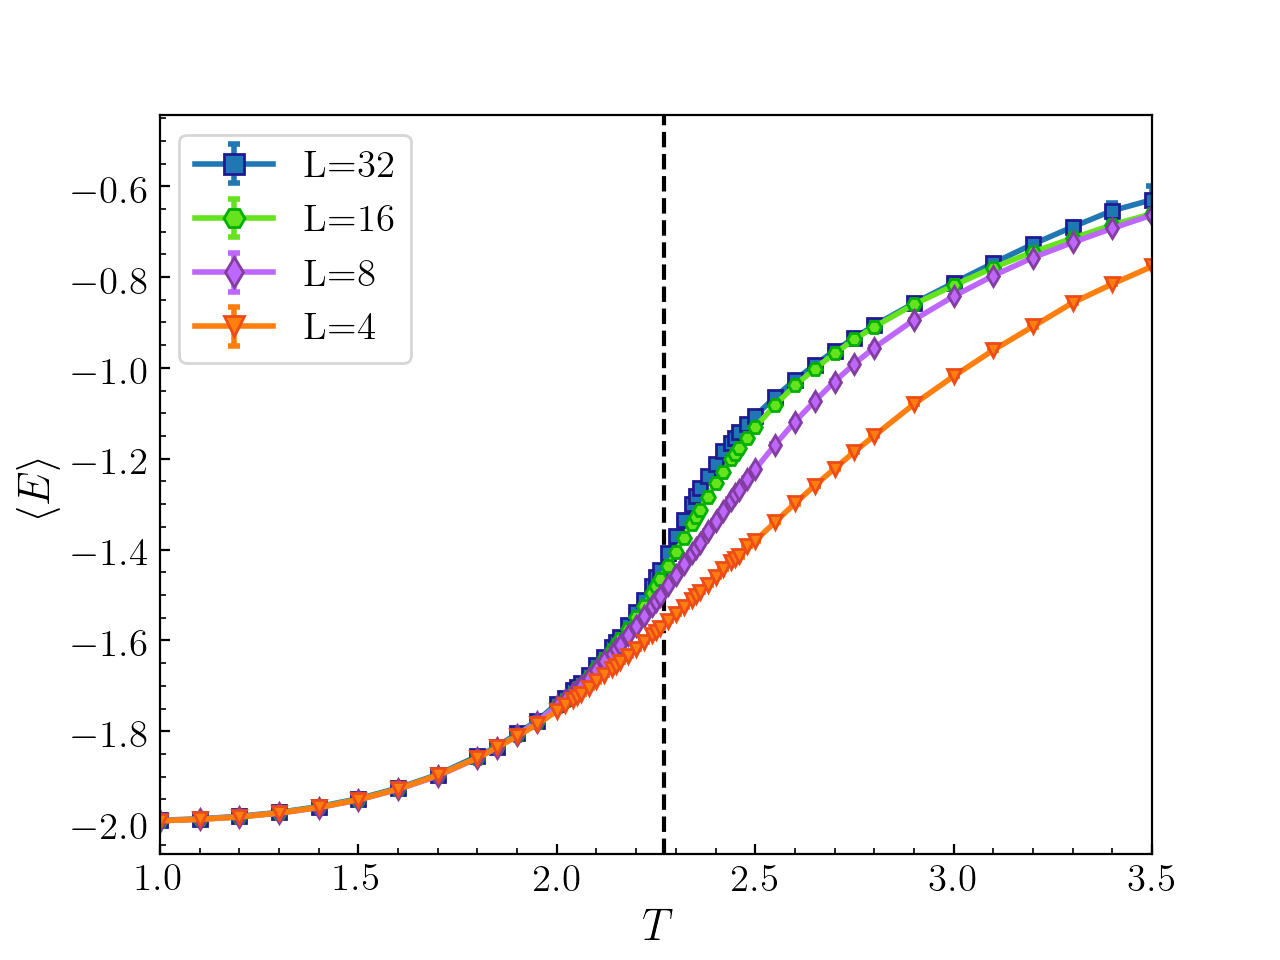

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(1.0, 3.5)

Text(0.5,0,'$T$')

Text(0,0.5,'$\\langle E\\rangle$')

Saving file to: ../plots/energy/energy_all_58.png


In [72]:
fig, ax = plt.subplots()
ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(specific_heat32._energy_temps, specific_heat32._avg_energy,
            yerr=specific_heat32._energy_error,
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.0,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(specific_heat16._energy_temps, specific_heat16._avg_energy,
            yerr=specific_heat16._energy_error,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')
ax.errorbar(specific_heat8._energy_temps, specific_heat8._avg_energy,
            yerr=specific_heat8._energy_error,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            capsize=2, capthick=2, 
            label='L=8')
ax.errorbar(specific_heat4._energy_temps, specific_heat4._avg_energy,
            yerr=specific_heat4._energy_error,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='-',
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel(r"$\langle E\rangle$", fontsize=16)

out_dir = '../plots/energy/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'energy_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

## Specific Heat

<IPython.core.display.Javascript object>


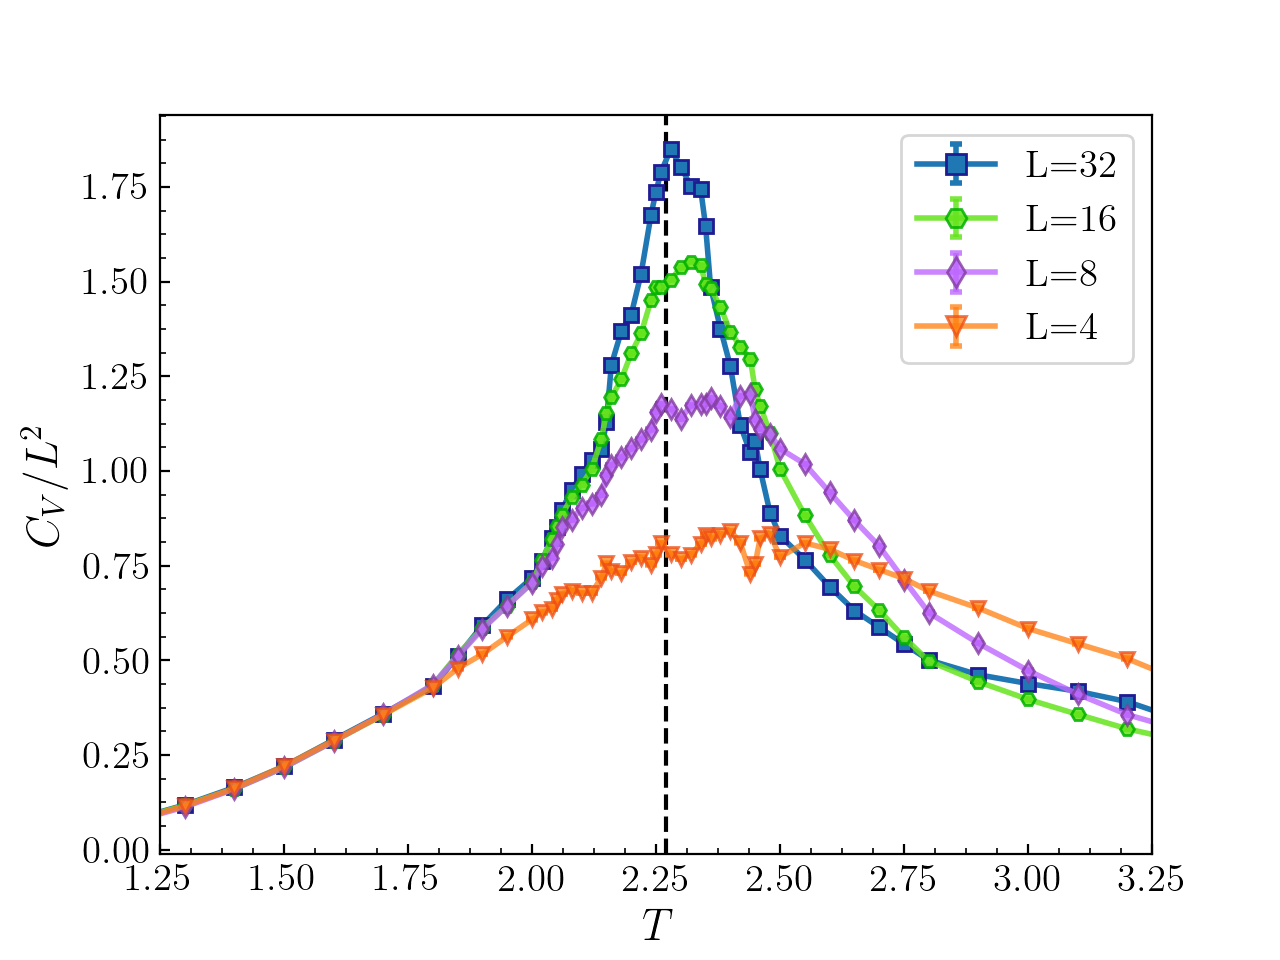

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(1.25, 3.25)

Text(0.5,0,'$T$')

Text(0,0.5,'$C_V/L^2$')

Saving file to: ../plots/specific_heat/specific_heat_all_44.png


In [73]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(specific_heat32._spec_heat_temps, specific_heat32._spec_heat,
            yerr=specific_heat32._spec_heat_err,
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2., capsize=2., capthick=2.,
            alpha=1.0, label='L=32')
            
#ax.plot(specific_heat16._specific_heat_temps, specific_heat16._specific_heat,
ax.errorbar(specific_heat16._spec_heat_temps, specific_heat16._spec_heat,
            yerr=specific_heat16._spec_heat_err,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2., alpha=0.85, ls='-',
            elinewidth=2., capsize=2., capthick=2.,
            fillstyle='full', label='L=16')

#ax.plot(specific_heat8._specific_heat_temps, specific_heat8._specific_heat,
ax.errorbar(specific_heat8._spec_heat_temps, specific_heat8._spec_heat,
            yerr=specific_heat8._spec_heat_err,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            elinewidth=2., capsize=2., capthick=2.,
            lw=2., alpha=0.8, ls='-', label='L=8')

#ax.plot(specific_heat4._specific_heat_temps, specific_heat4._specific_heat,
ax.errorbar(specific_heat4._spec_heat_temps, specific_heat4._spec_heat,
            yerr=specific_heat4._spec_heat_err,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2., 
            elinewidth=2., capsize=2., capthick=2.,
            alpha=0.75, ls='-', label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1.25, 3.25)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$C_V/L^2$', fontsize=16)
#plt.savefig('plots/specific_heat_all.png', dpi=600, bbox_inches='tight')
out_dir = '../plots/specific_heat/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'specific_heat_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

## $\langle \Delta_{N_b}^2\rangle$ Plots

### $\langle \Delta_{N_b}^2\rangle$

<IPython.core.display.Javascript object>


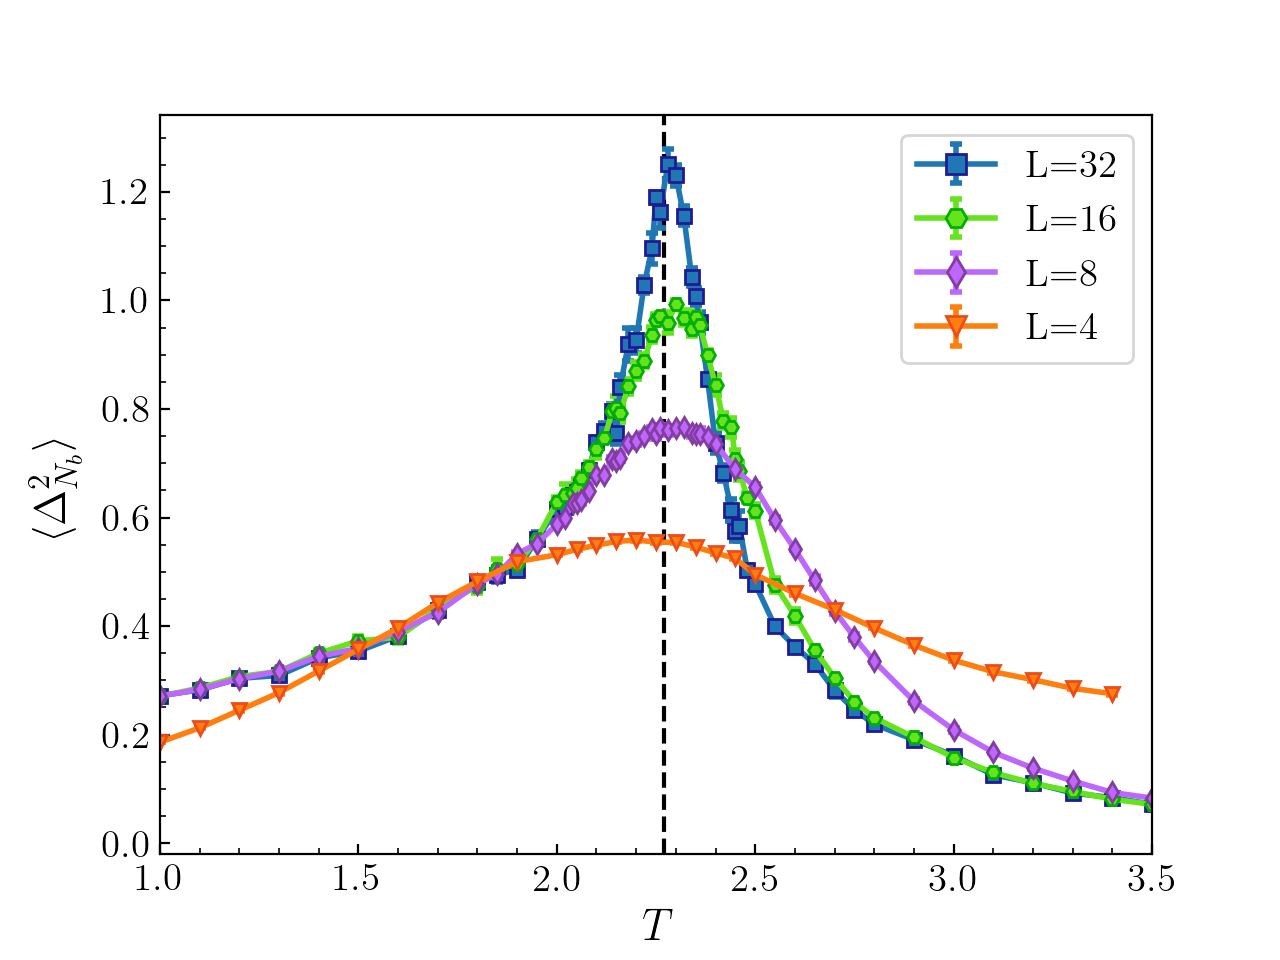

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(1.0, 3.5)

Text(0.5,0,'$T$')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle$')

Saving file to: ../plots/bond_stats/delta_Nb_all_48.png


In [74]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(Nb32_temps, delta_Nb32[:,0]/(2*32*32), 
            yerr=delta_Nb32[:,1]/(2*32*32),
            marker='s', color='C0', alpha=1.,
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(Nb16_temps, delta_Nb16[:,0]/(2*16*16), 
            yerr=delta_Nb16[:,1]/(2*16*16),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar(Nb8_temps, delta_Nb8[:,0]/(2*8*8),
            yerr=delta_Nb8[:,1]/(2*8*8),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
ax.errorbar(Nb4_temps, delta_Nb4[:,0]/(2*4*4), 
            yerr=delta_Nb4[:,1]/(2*4*4),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')


ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$", fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
out_dir = '../plots/bond_stats/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### Rescaled:  $\langle \Delta_{N_b}^2\rangle / L^{1/4}$ vs.  $(T-Tc)L^{1/4}$

<IPython.core.display.Javascript object>


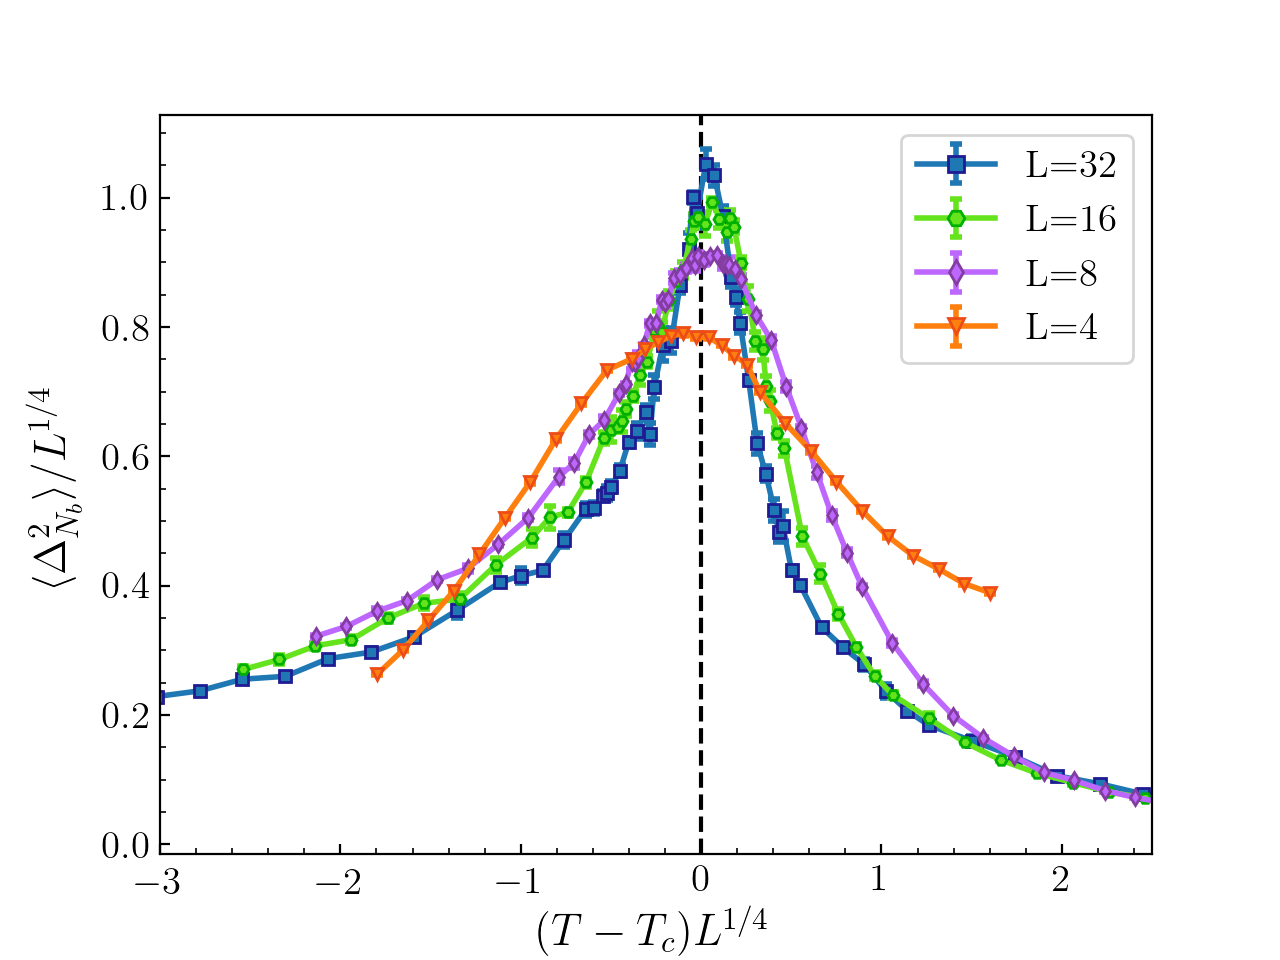

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(-3.0, 2.5)

Text(0.5,0,'$(T - T_c)L^{1/4}$')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle / L^{1/4}$')

Saving file to: ../plots/bond_stats/rescaled/delta_Nb_all_rescaled_10.png


In [75]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
#ax.plot(temps32, flucts32/(2*32*32),
ax.errorbar((Nb32_temps-Tc)*32**(1./4), delta_Nb32[:,0]/(32*32*32**(1./4)), 
            yerr=delta_Nb32[:,1]/(32*32*32**(1./4)),
            marker='s', color='C0', alpha=1.,
            markersize=4,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=32')
            
#ax.plot(temps16, flucts16/(2*16*16),
ax.errorbar((Nb16_temps-Tc)*16**(1./4), delta_Nb16[:,0]/(16*16*16**(1./4)), 
            yerr=delta_Nb16[:,1]/(16*16*16**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=4., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')

#ax.plot(temps8, flucts8/(2*8*8),
ax.errorbar((Nb8_temps-Tc)*8**(1./4), delta_Nb8[:,0]/(8*8*8**(1./4)), 
            yerr=delta_Nb8[:,1]/(8*8*8**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=4, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')


#ax.plot(temps4, flucts4/(2*4*4),
ax.errorbar((Nb4_temps-Tc)*4**(1./4), delta_Nb4[:,0]/(4*4*4**(1./4)), 
            yerr=delta_Nb4[:,1]/(4*4*4**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=4,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')


ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(-3., 2.5)
#ax.grid(True)
ax.set_xlabel('$(T - T_c)L^{1/4}$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle / L^{1/4}$", fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
out_dir = '../plots/bond_stats/rescaled/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_rescaled_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### $\langle \Delta_{N_b}^2\rangle$ (blocked)

<IPython.core.display.Javascript object>


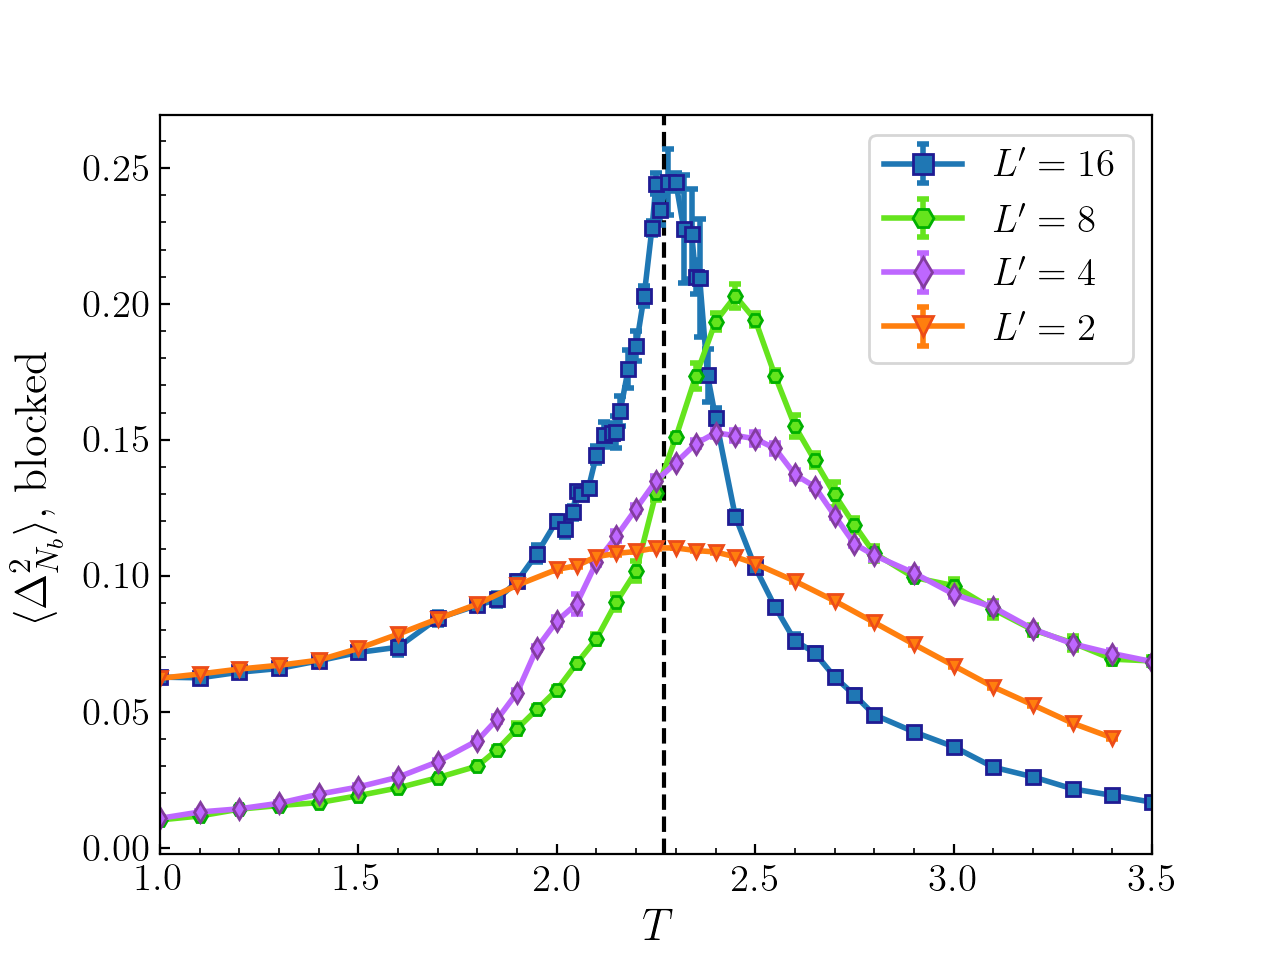

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(1.0, 3.5)

Text(0.5,0,'$T$')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle$, blocked')

Saving file to: ../plots/bond_stats/blocked/delta_Nb_all_19.png


In [76]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar(Nb32b_temps, delta_Nb32b[:,0]/(2*32*32), 
            yerr=delta_Nb32b[:,1]/(2*32*32),
            marker='s', color='C0', alpha=1.,
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2.,  capsize=2, capthick=2,
            label="$L^{\prime}=16$")
ax.errorbar(Nb16b_temps, delta_Nb16b[:,0]/(2*16*16),
            yerr=delta_Nb16b[:,1]/(2*16*16),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label="$L^{\prime}=8$")
ax.errorbar(Nb8b_temps, delta_Nb8b[:,0]/(2*8*8), 
            yerr=delta_Nb8b[:,1]/(2*8*8),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label="$L^{\prime}=4$")
ax.errorbar(Nb4b_temps, delta_Nb4b[:,0]/(2*4*4), 
            yerr=delta_Nb4b[:,1]/(2*4*4),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label="$L^{\prime}=2$")


ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
#ax.grid(True)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$, blocked", fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
out_dir = '../plots/bond_stats/blocked/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

### Rescaled (blocked):  $\langle \Delta_{N_b}^2\rangle / L^{1/4}$ vs.  $(T-Tc)L^{1/4}$

<IPython.core.display.Javascript object>


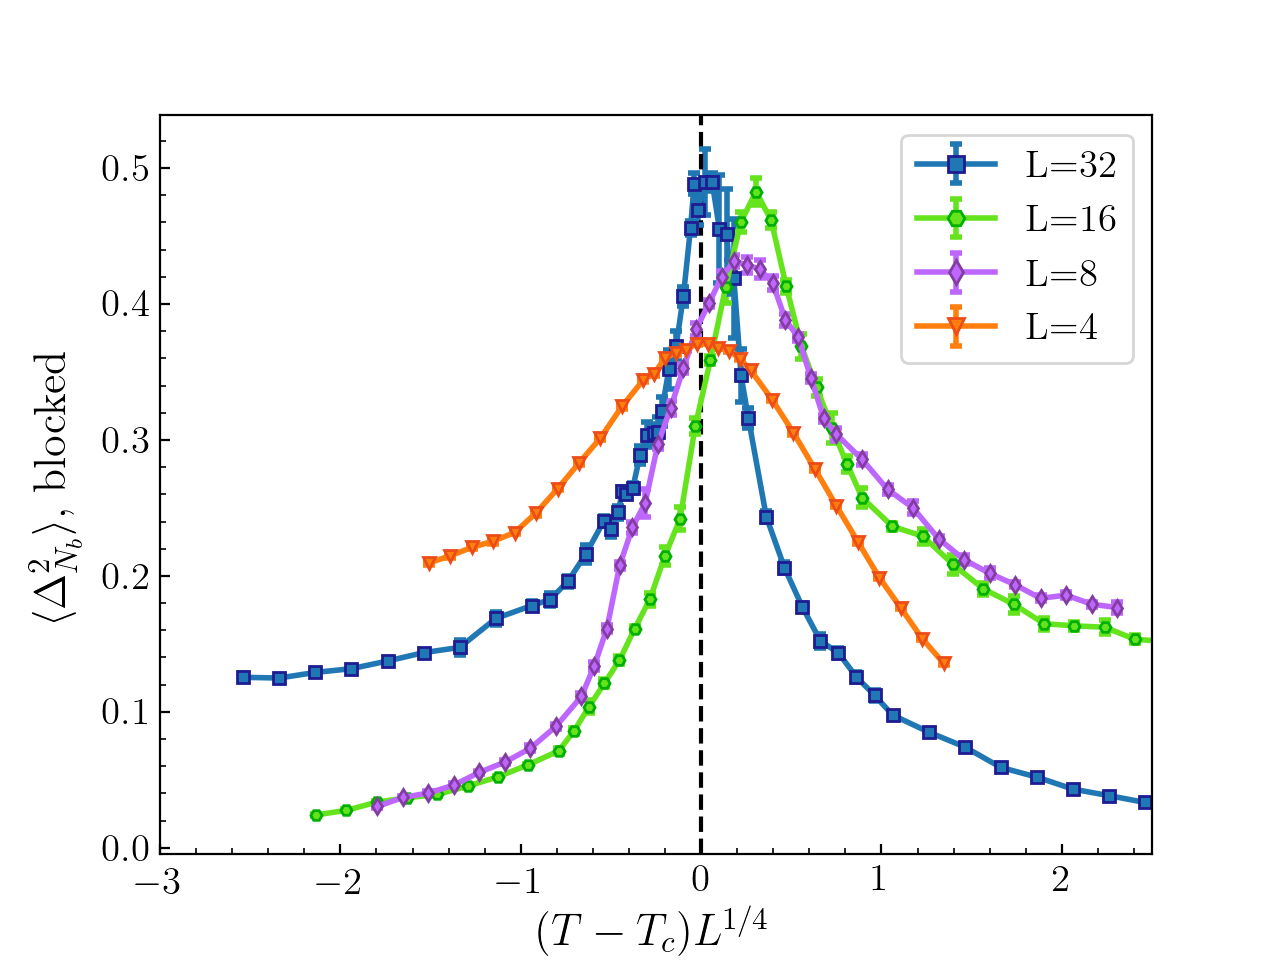

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(-3.0, 2.5)

Text(0.5,0,'$(T - T_c) L^{1/4}$')

Text(0,0.5,'$\\langle \\Delta_{N_b}^2\\rangle$, blocked')

In [77]:
fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((Nb32b_temps-Tc)*16**(1./4), delta_Nb32b[:,0]/(2*16*16*16**(1./4)), 
yerr=delta_Nb32b[:,1]/(2*16*16*16**(1./4)),
            marker='s', color='C0', alpha=1.,
            markersize=4,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2,
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=32')
ax.errorbar((Nb16b_temps-Tc)*8**(1./4), delta_Nb16b[:,0]/(2*8*8*8**(1./4)), 
            yerr=delta_Nb16b[:,1]/(2*8*8*8**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=4., 
            lw=2, alpha=1., ls='-', fillstyle='full',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=16')
ax.errorbar((Nb8b_temps-Tc)*4**(1./4), delta_Nb8b[:,0]/(2*4*4*4**(1./4)), 
            yerr=delta_Nb8b[:,1]/(2*4*4*4**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=4, 
            lw=2, alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=8')
ax.errorbar((Nb4b_temps-Tc)*2**(1./4), delta_Nb4b[:,0]/(2*2*2*2**(1./4)), 
            yerr=delta_Nb4b[:,1]/(2*2*2*2**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=4,  lw=2, 
            alpha=1., ls='-',
            elinewidth=2.,  capsize=2, capthick=2,
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(-3., 2.5)
ax.set_xlabel('$(T - T_c) L^{1/4}$', fontsize=16)
ax.set_ylabel(r"$\langle \Delta_{N_b}^2\rangle$, blocked", fontsize=16)
#ax.set_title('Specific Heat Capacity $C_V$ vs. $T$', fontsize=22)
out_dir = '../plots/bond_stats/blocked/rescaled/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [int(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = latest_num + 1
out_file = out_dir + 'delta_Nb_all_rescaled_{}.png'.format(new_num)
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()

## PCA  $(\lambda_1)$ Plots

### $\lambda_1$

<IPython.core.display.Javascript object>


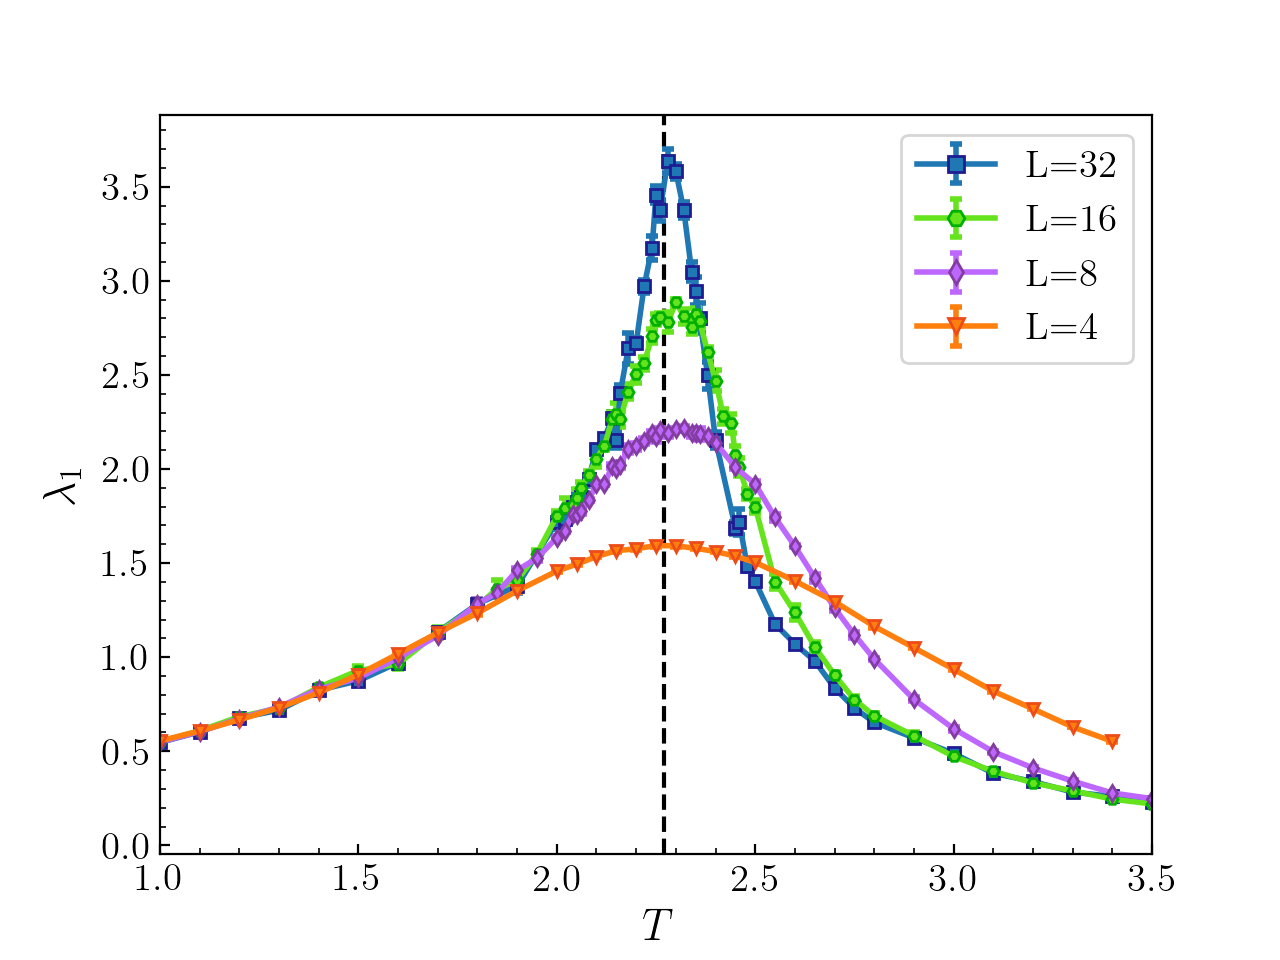

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(1, 3.5)

Text(0.5,0,'$T$')

Text(0,0.5,'$\\lambda_1$')

Saving file to: ../plots/pca/leading_eigenvalue_all_20.png


In [78]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')

ax.errorbar(pca32_temps, pca32_vals,
            yerr=list(pca32._err.values()),
            marker='s', color='C0',
            markersize=4,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label='L=32')
            
ax.errorbar(pca16_temps, pca16_vals,
            yerr=list(pca16._err.values()),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=4., 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            fillstyle='full', capsize=2, capthick=2, 
            label='L=16')
ax.errorbar(pca8_temps, pca8_vals,
            yerr=list(pca8._err.values()),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=4, 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            capsize=2, capthick=2, 
            label='L=8')
ax.errorbar(pca4_temps, pca4_vals,
            yerr=list(pca4._err.values()),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=4,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='-',
            label='L=4')

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1, 3.5)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\lambda_1$', fontsize=16)
out_dir = '../plots/pca/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'leading_eigenvalue_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()
plt.show()

### $\lambda_1$ (rescaled)

<IPython.core.display.Javascript object>


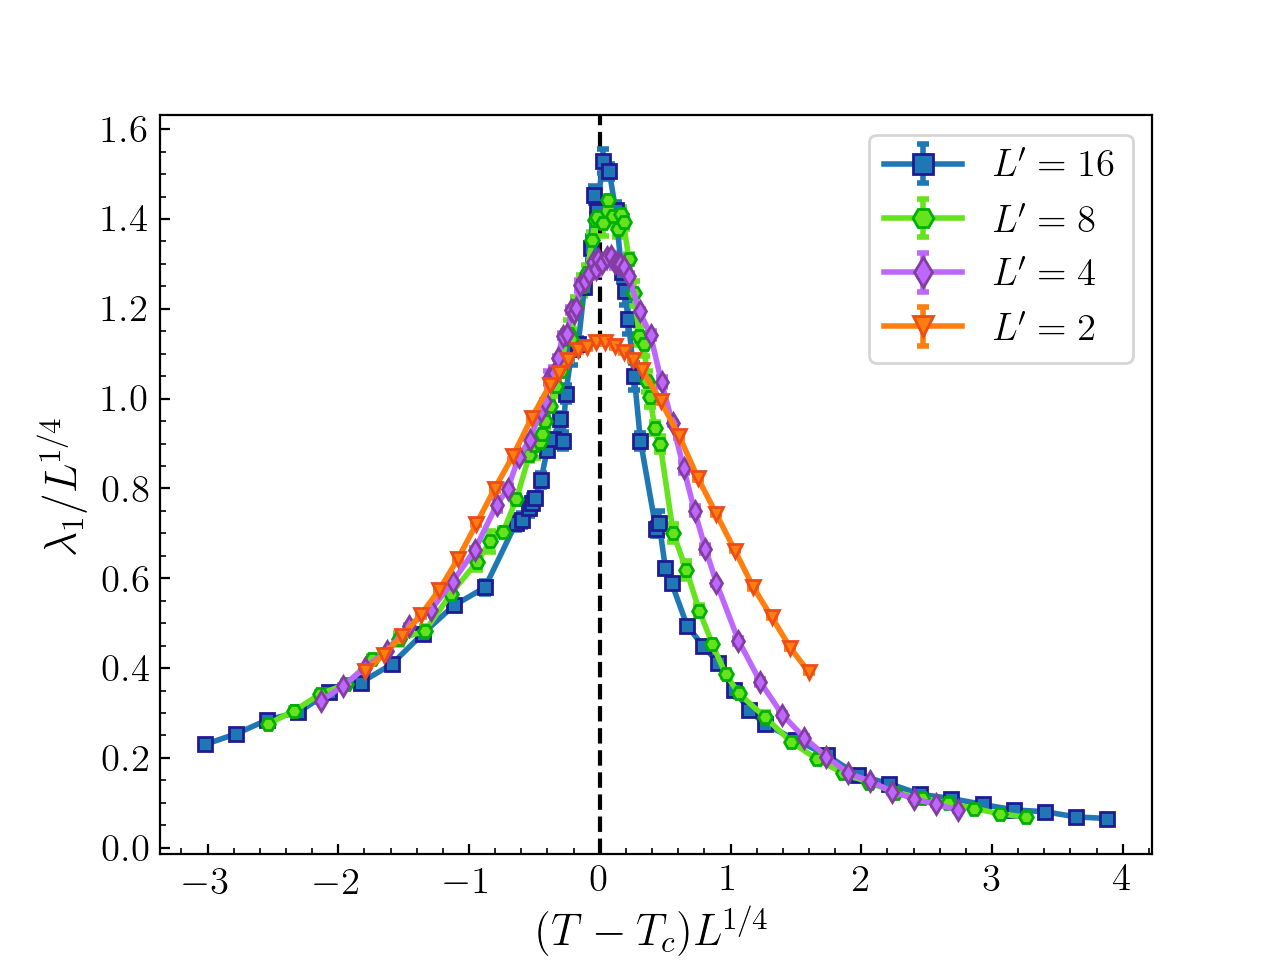

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'$(T - T_c)L^{1/4}$')

Text(0,0.5,'$\\lambda_1 / L^{1/4}$')

Saving file to: ../plots/pca/rescaled/leading_eigenvalue_all_rs_11.png


In [79]:
pca32_temps = np.array(pca32_temps)
pca32_vals = np.array(pca32_vals)
pca32_err = np.array(pca32_err)
pca16_temps = np.array(pca16_temps)
pca16_vals = np.array(pca16_vals)
pca16_err = np.array(pca16_err)
pca8_temps = np.array(pca8_temps)
pca8_vals = np.array(pca8_vals)
pca8_err = np.array(pca8_err)
pca4_temps = np.array(pca4_temps)
pca4_vals = np.array(pca4_vals)
pca4_err = np.array(pca4_err)

fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((pca32_temps-Tc)*32**(1./4), pca32_vals/(32**(1./4)),
            yerr=pca32_err/(32**(1./4)),
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label=r"$L^{\prime}=16$")
ax.errorbar((pca16_temps - Tc)*16**(1./4), pca16_vals/(16**(1./4)),
            yerr=pca16_err/(16**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            fillstyle='full', capsize=2, capthick=2, 
            label=r"$L^{\prime}=8$")
ax.errorbar((pca8_temps - Tc)*8**(1./4), pca8_vals/(8**(1./4)),
            yerr=pca8_err/(8**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            capsize=2, capthick=2, 
            label=r"$L^{\prime}=4$")
ax.errorbar((pca4_temps - Tc)*4**(1./4), pca4_vals/(4**(1./4)),
            yerr=pca4_err/(4**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='-',
            label=r"$L^{\prime}=2$")

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
#ax.set_xlim(1., 3.5)
ax.set_xlabel('$(T - T_c)L^{1/4}$', fontsize=16)
ax.set_ylabel('$\lambda_1 / L^{1/4}$', fontsize=16)
out_dir = '../plots/pca/rescaled/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = int(max(existing))
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'leading_eigenvalue_all_rs_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()
plt.show()

### $\lambda_1^{blocked}$

<IPython.core.display.Javascript object>


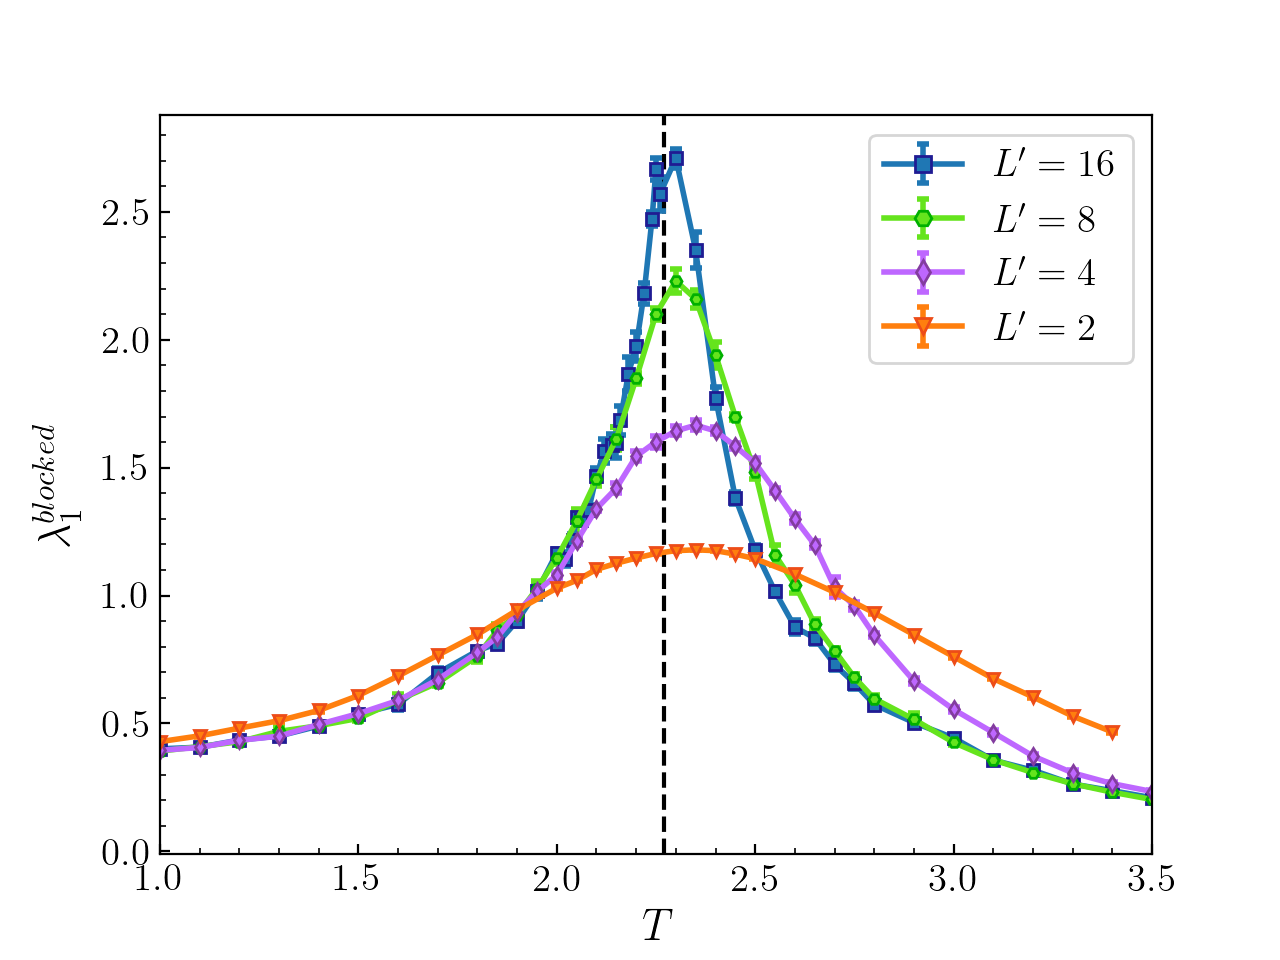

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

(1.0, 3.5)

Text(0.5,0,'$T$')

Text(0,0.5,'$\\lambda_1^{blocked}$')

Saving file to: ../plots/pca/blocked/double_bonds_0/leading_eigenvalue_all_14.png


In [80]:
fig, ax = plt.subplots()

ax.axvline(x=Tc, linestyle='--', color='k')#, label='$T = T_c$')

ax.errorbar(pca32b_temps, pca32b_vals,
            yerr=pca32b_err,
            marker='s', color='C0',
            markersize=4,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label=r"$L^{\prime}=16$")
ax.errorbar(pca16b_temps, pca16b_vals,
            yerr=pca16b_err,
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=4., 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            fillstyle='full', capsize=2, capthick=2, 
            label=r"$L^{\prime}=8$")
ax.errorbar(pca8b_temps, pca8b_vals,
            yerr=pca8b_err,
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=4, 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            capsize=2, capthick=2, 
            label=r"$L^{\prime}=4$")
ax.errorbar(pca4b_temps, pca4b_vals,
            yerr=pca4b_err,
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=4,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='-',
            label=r"$L^{\prime}=2$")

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
ax.set_xlim(1., 3.5)
ax.set_xlabel('$T$', fontsize=16)
ax.set_ylabel('$\lambda_1^{blocked}$', fontsize=16)
out_dir = '../plots/pca/blocked/double_bonds_0/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'leading_eigenvalue_all_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()
plt.show()

### $\lambda_1^{blocked}$ (rescaled)

<IPython.core.display.Javascript object>


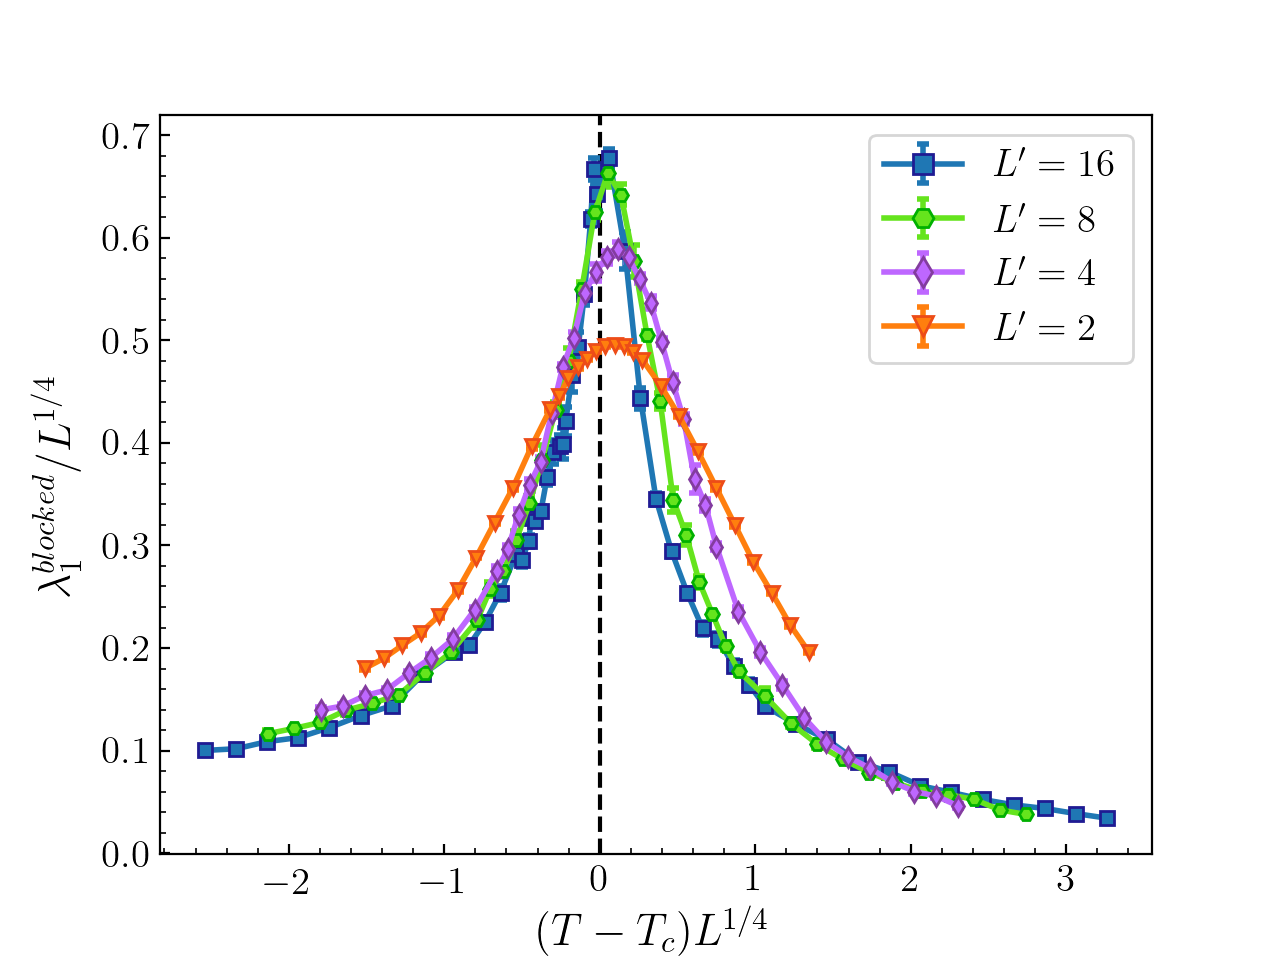

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

<Container object of 3 artists>

Text(0.5,0,'$(T - T_c)L^{1/4}$')

Text(0,0.5,'$\\lambda_1^{blocked} / L^{1/4}$')

Saving file to: ../plots/pca/blocked/rescaled/leading_eigenvalue_all_rs_9.png


In [81]:
pca32b_temps = np.array(pca32b_temps)
pca32b_vals = np.array(pca32b_vals)
pca32b_err = np.array(pca32b_err)
pca16b_temps = np.array(pca16b_temps)
pca16b_vals = np.array(pca16b_vals)
pca16b_err = np.array(pca16b_err)
pca8b_temps = np.array(pca8b_temps)
pca8b_vals = np.array(pca8b_vals)
pca8b_err = np.array(pca8b_err)
pca4b_temps = np.array(pca4b_temps)
pca4b_vals = np.array(pca4b_vals)
pca4b_err = np.array(pca4b_err)

fig, ax = plt.subplots()

ax.axvline(x=0, linestyle='--', color='k')#, label='$T = T_c$')
ax.errorbar((pca32b_temps-Tc)*16**(1./4), pca32b_vals/(2*16**(1./4)),
            yerr=pca32b_err/(2*16**(1./4)),
            marker='s', color='C0',
            markersize=5,  markeredgecolor='#1f1b93',
            ls='-', fillstyle='full', lw=2.,
            elinewidth=2.,  alpha=1.,
            capsize=2, capthick=2,
            label=r"$L^{\prime}=16$")
ax.errorbar((pca16b_temps - Tc)*8**(1./4), pca16b_vals/(2*8**(1./4)),
            yerr=pca16b_err/(2*8**(1./4)),
            marker='H', color='#65e41d',
            markeredgecolor='#00B000', markersize=5., 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            fillstyle='full', capsize=2, capthick=2, 
            label=r"$L^{\prime}=8$")
ax.errorbar((pca8b_temps - Tc)*4**(1./4), pca8b_vals/(2*4**(1./4)),
            yerr=pca8b_err/(2*4**(1./4)),
            marker='d', fillstyle='full', color='#be67ff',
            markeredgecolor='#833c9f', markersize=5, 
            lw=2., elinewidth=2.,  alpha=1., ls='-',
            capsize=2, capthick=2, 
            label=r"$L^{\prime}=4$")
ax.errorbar((pca4b_temps - Tc)*2**(1./4), pca4b_vals/(2*2**(1./4)),
            yerr=pca4b_err/(2*2**(1./4)),
            color='C1', markeredgecolor='#ed4c18', marker='v', 
            fillstyle='full', markersize=5,  lw=2., elinewidth=2., 
            alpha=1., capsize=2, capthick=2,  ls='-',
            label=r"$L^{\prime}=2$")

ax.legend(loc='best', markerscale=1.5, fontsize=14)#, frameon=False)
#ax.set_xlim(1., 3.5)
ax.set_xlabel('$(T - T_c)L^{1/4}$', fontsize=16)
ax.set_ylabel('$\lambda_1^{blocked} / L^{1/4}$', fontsize=16)
out_dir = '../plots/pca/blocked/rescaled/'
if not os.path.exists(out_dir):
    os.makedirs(out_dir)
existing = [float(i.split('_')[-1].rstrip('.png')) for i in os.listdir(out_dir) 
            if i.endswith('.png')]
try:
    latest_num = max(existing)
except ValueError:
    latest_num = 0
new_num = int(latest_num + 1)
out_file = out_dir + 'leading_eigenvalue_all_rs_{}.png'.format(new_num)
print("Saving file to: {}".format(out_file))
plt.savefig(out_file, dpi=600, bbox_inches='tight')
plt.show()
plt.show()